# <center> <h1>🦾 `Trainer` - основа хорошей тренировки! 🏋‍♂️</h1> </center>

### Оглавление ноутбука
<img src='https://i.imgur.com/Nh91XqM.png' align="right" width="508" height="428" >
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#p1">🤔 Зачем нужен Trainer?</a></li>
<li><a href="#p2">🤹‍♀️ Параметры Trainer</a></li>
<li><a href="#p7">🔫 Model, Trainer & 2 smoking CallBacks 🔫</a></li>
<li><a href="#p3">📏 Torchmetrics - удобный доступ к любым метрикам! 📐</a></li>
<li><a href="#p4">📏 TorchMetrics в PyTorch Lightning ⚡</a></li>
<li><a href="#p5">🎚 Tuner - подбираем идеальные гиперпараметры! </a></li>
<li><a href="#p6">🧸 Выводы и заключения ✅ </a></li>


    
</ul></font></p>

### 🧑‍🎓 В этом ноутбуке разберем работу с `Trainer`, его `Callbaсks` и библиотеку `Torchmetrics`

# <center id="p1">  🤔 Зачем нужен Trainer?</center>

<div class="alert alert-info">

Тренер в реальной жизни 🍏 тренирует вас, давая обратную связь о ваших успехах, делая отчеты о прогрессе, помогая вам добиться результатов. 

`Trainer` из `Lightning` делает тоже с вашей моделью  💪:
- 🏋️ Сам ее обучает, используя `EarlyStopping`, `Graident Accumulation ` и пр.
- 🤹‍♂️ Собирает метрики по мере обучения
- 🚀 Хотите обучать нейронку на GPU? А если GPU несколько - не проблема, можно запустить обучение хоть на 100 GPU

<div class="alert alert-success">

## Основные фишки:

- 🐘 Больше не нужно писать огромный `train loop` для обучения вашей нейронки. В `Trainer` уже все реализовано.
- 🖊 Использование любого логера. Воспользуйтесь `W&B`, `CometML` или [другими]("https://pytorch-lightning.readthedocs.io/en/2.5.0/pytorch/api_references.html#loggers") - `Trainer` сделает все за вас.
- 🌍 Распределенное обучение. Если у вас есть несколько GPU, то есть возможность ускорить обучение

# <center> 👨‍💻 Настраиваемся на работу  </center>

In [1]:
from dataclasses import dataclass
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from lightning import Trainer, LightningModule, LightningDataModule
import lightning.pytorch as pl

## Конфиг

In [2]:
@dataclass
class CFG:
    model_name: str = 'Lightning ⚡️ Improved'
    seed: int = 2025
    device: str = "cuda"  # 'cpu'
    device_count: int = 1
    hidden_size: int = 128
    dropout: float = 0.1

    lr: float = 1e-3
    batch_size: int = 128
    num_workers: int = 4
    epochs: int = 20

cfg = CFG()

### Фиксируем seed

In [3]:
from lightning.pytorch import seed_everything

seed_everything(cfg.seed)

Seed set to 2025


2025

# <center> 🤹 Подгружаем данные </center>

In [3]:
url = 'https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/quickstart_train.csv'
rides_info = pd.read_csv(url)
rides_info.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


<div class="alert alert-info">

🌪 В данных есть как текстовые, так и категориальные данные. Для корректной работы нейронки преобразуем их 

In [4]:
# Препроцессинг категориальных данных
drop_cols = ["car_id", "target_reg", "target_class"]
cat_cols = ["car_type", "fuel_type", "model"]
rides_info = pd.get_dummies(rides_info, columns=cat_cols)
rides_info.fillna(rides_info.median(numeric_only=True), inplace=True)
num_cols = [col for col in list(rides_info.columns) if col not in drop_cols]

In [5]:
# Нормализуем данные и кодируем таргет

scaler = RobustScaler()
le = LabelEncoder()

df = scaler.fit_transform(rides_info[num_cols])
df = pd.DataFrame(df, columns=num_cols)

target_scaler = RobustScaler()
target = target_scaler.fit_transform(rides_info["target_reg"].values.reshape(-1, 1))

df["target_reg"] = target
df["target_class"] = le.fit_transform(rides_info["target_class"]).reshape((-1, 1))

In [6]:
# Разбиваем датасет на трэйн и тест выборки
train, test = train_test_split(df, test_size=0.2, random_state=cfg.seed)

cfg.num_features = train.shape[1] - 2  # количество фичей, подаваемое на вход
cfg.num_tar_class = (
    train.target_class.nunique()
)  # количество выходов равно количеству предсказываемых классов

In [7]:
df.head(3)

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,...,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4,target_reg,target_class
0,-0.460317,0.5,0.258414,0.75,0.567305,-0.187985,0.0,0.129562,0.019027,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.022894,0
1,-0.365079,0.5,0.303616,0.75,0.072227,0.841243,-0.1,0.237381,1.085987,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.238877,2
2,1.539683,-1.0,-0.903502,-0.25,0.626258,0.465096,0.0,-1.077932,0.235335,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219438,7


<div class="alert alert-success">

После преобразования данных перед подачей в нейронную сеть важно создать `Dataset` и `Dataloader`, чтобы удобно обучать модель.

Но в `Lightning` есть модуль, который объединяет два этих класса - `LightningDataModule` 🧰:
* Вы создаете только 1 класс, который содержит `train`, `valid`, `test` части
* Передаете этот класс нашему `Trainer` и все!

Правда удобно? Давайте посмотрим, как это реализовывается 😏

# <center> 🛠 `Dataset` для модели (не бро) </center>

<div class="alert alert-info">

Посмотрим сначала, как это реализовывается в `PyTorch`

In [8]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]

        data = row.drop(labels=["target_reg", "target_class"])
        data = torch.FloatTensor(data.values.astype("float"))
        tar_reg = torch.tensor(row["target_reg"]).float()
        tar_class = row["target_class"].astype("int")

        return data, tar_reg, tar_class

In [9]:
train_datasets = {"train": Rides(train), "val": Rides(test)}

In [10]:
dataloaders_dict = {x: torch.utils.data.DataLoader(train_datasets[x], 
                                                   batch_size=CFG.batch_size, 
                                                   shuffle=True, 
                                                   num_workers=CFG.num_workers)
                    for x in ['train', 'val']}

## <center> 🏆 `Dataset`, который может все! </center>

<div class="alert alert-info">

А теперь добавляем магию `PyTorch-Lightning` ⚡

In [11]:
from lightning import LightningDataModule

class RidesLightning(LightningDataModule):
    def __init__(self, cfg: CFG, train_datasets: dict) -> None: 
        # Сохраняем переменные для дальнейшей работы
        super().__init__()

        self.cfg = cfg
        self.datasets = train_datasets
        self.batch_size = self.cfg.batch_size

    def setup(self, stage: str):
        # Создаем Dataset'ы
        self.train = self.datasets["train"]
        self.val = self.datasets["val"]

    
    def _make_dataloader(self, dataset, cfg):
        # Общий метод для создания DataLoader
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.cfg.num_workers,
            pin_memory=True
        )

    def train_dataloader(self):
        # Возвращаем Train Dataloader
        return self._make_dataloader(self.train, cfg)
    
    def val_dataloader(self):
        # Возвращаем Valid Dataset
        return self._make_dataloader(self.val, cfg)
    
    def teardown(self, stage: str):
        # Функция, которая выполняется после создания Dataloader - здесь можно удалить ненужные компоненты
        del self.train, self.val

In [12]:
dataset = RidesLightning(cfg, train_datasets)

# <center> ⚡️ Модель <center>

In [13]:
from lightning import LightningModule

class LightningModel(LightningModule): # Элемент от Lightning
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.lr = cfg.lr # ВАЖНО! Сохраняйте lr в модели

        self.mlp = nn.Sequential(
            nn.Linear(cfg.num_features, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.LeakyReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.GELU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size // 2),
        )
        # Так как два таргета, делаем две головы - одна для регрессии, другая - классификации
        self.regressor = nn.Sequential(nn.Linear(cfg.hidden_size // 2, 1))
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, cfg.num_tar_class)
        )
        
        self.regressor = nn.Sequential(nn.Linear(cfg.hidden_size // 2, 1))

        self.regression_criterion = nn.MSELoss()
        self.classification_criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Forward pass through the network
        x = self.mlp(x)
        tar_reg = self.regressor(x)
        tar_class = self.classifier(x)
        return tar_reg.view(-1), tar_class
    
    def basic_step(self, batch, batch_idx, step: str):
        # Получаем данные
        data, reg_target, clas_target = batch

        pred_reg, pred_clas = self(data)

        loss_reg = self.regression_criterion(pred_reg, reg_target)
        loss_class = self.classification_criterion(pred_clas, clas_target)
        loss = loss_reg + loss_class

        loss_dict = {
            f"{step}/loss": loss,
            f"{step}/reg_loss": loss_reg,
            f"{step}/reg_class": loss_class
        }

        self.log_dict(loss_dict, prog_bar=True)

        return loss_dict
    
    def training_step(self, batch, batch_idx):
        loss_dict = self.basic_step(batch, batch_idx, "train")
        return loss_dict["train/loss"]
    
    def validation_step(self, batch, batch_idx):
        loss_dict = self.basic_step(batch, batch_idx, "valid")
        return loss_dict["valid/loss"]
    
    
    def test_step(self, batch, batch_idx):
        loss_dict = self.basic_step(batch, batch_idx, "test")
        return loss_dict["test/loss"]
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.cfg.epochs)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train/loss",
                "interval": "epoch",
                "reduce_on_plateau": True,
            }
        }

In [14]:
model = LightningModel(cfg)
model

LightningModel(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=9, bias=True)
  )
  (regression_criterion): MSELoss()
  (classification_criterion): CrossEntropyLoss()
)

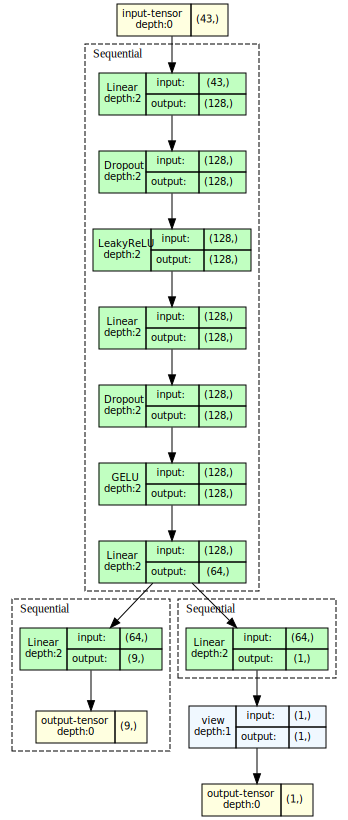

In [15]:
# Посмотрим какая модель у нас получилась
from torchview import draw_graph

model_graph = draw_graph(model, input_size=[cfg.num_features], expand_nested=True)
model_graph.visual_graph

<div class="alert alert-success">

Мы написали функциональный датасет и нейронку

Пора это объединить и обучить нейронку на данных - в этом нам поможет `Trainer`

# <center id="p2"> 🤠  Лучший Trainer на всем диком Западе </center>

<div class="alert alert-info">

Основные параметры `Trainer`:
* `accelerator` - если вы хотите тренировать модель на `cpu`, `gpu` или же `tpu`, `hpu` и прочих устройствах
* `devices` - кол-во `cpu`, `gpu`. Можно поставить `-1` - будут использоваться все ресурсы
* `logger` - Логгер обучения модели. Можно использовать: `WandbLogger`, `MLFlowLogger`, `NeptuneLogger` и прочие. Весь список логгеров можно увидеть здесь: https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/api_references.html#loggers
* `max_epochs` - Кол-во эпох обучения модели
* `max_steps` - Кол-во батчей, которое увидит модель в эпохе
* `check_val_every_n_epoch` - Проверять val часть через каждые n эпох обучения
* `fast_dev_run` - запускает отладочную эпоху на train и val части, чтобы убедиться все ли исправно работает
* `deterministic` - фиксируем seed. Если раньше не делали `seed_everything`! 
* `callbacks` - одна из основных фишек тренера. Позволяет добавить `EarlyStopping` к модели за одну строчку! И прочие плюшки

Все параметры можно найти здесь: https://pytorch-lightning.readthedocs.io/en/2.5.0/pytorch/common/trainer.html#trainer-class-api

## <center> 🤼‍♀️ Самый базовый Тренер </center>

In [16]:
trainer = Trainer(
    accelerator='gpu', # Где обучаем нейронку
    devices=cfg.device_count, # Если несколько GPU, TPU
    fast_dev_run=True, # Отладочный запуск крайне важен!
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [17]:
trainer.fit(model, datamodule=dataset)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | mlp                      | Sequential       | 30.4 K | train
1 | regressor                | Sequential       | 65     | train
2 | classifier               | Sequential       | 585    | train
3 | regression_criterion     | MSELoss          | 0      | train
4 | classification_criterion | CrossEntropyLoss | 0      | train
----------------------------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
3

Training: |                                                                                                   …

Validation: |                                                                                                 …

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
`Trainer.fit` stopped: `max_steps=1` reached.


<div class="alert alert-success">

Модель обучается на train, val части, поэтому можем запускать и "целиковое" обучение. Давайте напишем самый базовый тренер, который будет сохранять веса модели и прекращать обучение, если `loss` начал расти.

# <center id="p7"> 🔫 Model, Trainer & 2 smoking CallBacks 🔫 </center>

<div class="alert alert-info">

`Callbacks` в **PyTorch Lightning** — это мощный инструмент, позволяющий добавлять в процесс обучения дополнительные функции, не изменяя основной код модели. Они обеспечивают модульность и повторное использование кода, что упрощает управление сложными экспериментами и улучшает читаемость проекта.

**Наиболее часто используемые callbacks:**

* `ModelCheckpoint`: Сохраняет модель на диск в определенные моменты времени, обычно при улучшении качества на валидационном наборе. Это обеспечивает возможность восстановления лучшей версии модели после завершения обучения.
* `EarlyStopping`: Отслеживает метрику и прекращает обучение, если качество модели перестает улучшаться, что помогает предотвратить переобучение и сэкономить вычислительные ресурсы.
* `LearningRateMonitor`: Автоматически отслеживает и логирует значения скорости обучения в течение тренировки, что полезно для анализа и отладки процесса обучения.
* `ProgressBar`: Отображает прогресс обучения в виде визуального индикатора, предоставляя информацию о текущем состоянии тренировки и ожидаемом времени завершения.
* `Timer`: Отслеживает время, затраченное на обучение, валидацию и тестирование, и может прерывать обучение при достижении заданного временного лимита.
* `DeviceStatsMonitor`: Автоматически отслеживает и логирует статистику устройства (например, GPU) во время обучения, валидации и тестирования, что помогает в мониторинге использования ресурсов.

Полный [список callback'ов в Lightning](https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/api_references.html#callbacks)

<div class="alert alert-warning">

В этом `Trainer` мы зададим основные параметры обучения модели и добавим `callbacks` - `EarlyStopping` и `ModelCheckpoint`.

В общем, `Trainer` решает все болячки самописных функций обучения и компанует их в лаконичный класс с удобным интерфейсом.

In [18]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    log_every_n_steps=10, # Как часто логируем метрики
    check_val_every_n_epoch=2, # Запускаем проверку val-части каждые 2 эпохи
    # Или можно использвать
    # val_check_interval=0.2 

    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=False, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Путь для сохранения модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, datamodule=dataset)

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /app/storage_local/Course/ml_instruments/models/Lightning ⚡️ Improved exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | mlp                      | Sequential       | 30.4 K | train
1 | regressor                | Sequential       | 65     | train
2 | classifier               | Sequential       | 585    | train
3 | regression_criterion     | MSELoss          | 0      | train
4 | classification_criterion | CrossEntropyLoss | 0      | train
----------------------------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
14        Modules in train mode
0         Module

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


<div class="alert alert-info">

**Основная идея:** 

`Захотели добавить что-то в пайплайн обучения --> нашли нужный callback в документации -> импортировали -> добавили в класс тренера -> пользуемся!`

Но если вы не нашли нужный модуль (что у вас за задача?! 🤯), то всегда можете написать собственный, отнаследовавшись от [данного класса](https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/api/lightning.pytorch.callbacks.Callback.html#lightning.pytorch.callbacks.Callback).

# <center id="p3"> 📏 Torchmetrics - удобный доступ к любым метрикам! 📐</center>

<p align="center">
  <img src="https://pypi-camo.freetls.fastly.net/cb0193441c6c9630fed5323fd6c1fa4146ca9ae2/68747470733a2f2f6769746875622e636f6d2f4c696768746e696e672d41492f746f7263686d6574726963732f7261772f76312e362e312f646f63732f736f757263652f5f7374617469632f696d616765732f6c6f676f2e706e67" />
</p>


<div class="alert alert-info">

**Torchmetrics** - фреймворк, внутри которого есть практически все необходимые метрики для работы с ИИ ([документация]( https://torchmetrics.readthedocs.io/en/v1.3.0/)). 
Фрэймворк отлично интегрирован для работы с **Lightning** 😉

Но давайте сначала посмотрим, как использовать этот инструмент отдельно.

In [21]:
!pip install torchmetrics -q

<div class="alert alert-info">

Существует два вида API:
* Функциональный вызов (как в sklearn). Все метрики лежат в `torchmetrics.functional`
* Класс с методами. Метрики лежат непосредственно в `torchmetrics` 

Весь список метрик можно увидеть здесь: https://torchmetrics.readthedocs.io/en/v1.3.0/all-metrics.html

Для каждой задачи удобен каждый метод, но мы сделаем упор на ООП-подходе

In [20]:
import torchmetrics as tm

## <center> 🎛 Функциональный подход </center>

In [21]:
y_true = torch.tensor([0, 1, 2, 1, 0])  # истинные метки
y_pred = torch.tensor([0, 2, 1, 1, 0])  # предсказания

In [22]:
accuracy = tm.functional.accuracy(y_pred, y_true, task="multiclass", num_classes=5)
accuracy.item()

0.6000000238418579

## <center> 🏫 Классовый подход </center>

In [23]:
# Задаем задачу (если необходимо) и количество классов (если необходимо)
accuracy = tm.Accuracy(task="multiclass", num_classes=5) 

In [24]:
accuracy(y_pred, y_true).item()

0.6000000238418579

<div class="alert alert-info">

Главная фича возможность использовать аккумулятивное накопление метрики. То есть при обучении по batch'ам можно вычислять метрику по всей эпохе, не заморачиваясь с ее накоплением и обнулением - **Torchmetrics** все сделает за вас!

In [25]:
fbeta = tm.FBetaScore(task="multiclass", num_classes=3, beta=0.25)

In [26]:
for _ in range(10):
    y_pred = torch.randint(1, 5, (3,))
    y_true = torch.randint(1, 5, (3,))

    metric = fbeta(y_true, y_pred)
    print(metric.item())

print(f"Средняя метрика: {fbeta.compute()}")
fbeta.reset() # Обнуляем накопившуюся метрику

0.3333333432674408
0.3333333432674408
0.3333333432674408
0.0
0.0
0.0
0.0
0.0
0.3333333432674408
0.3333333432674408
Средняя метрика: 0.1666666716337204


<div class="alert alert-info">

Также есть возможность автоматической отрисовки графиков обучения, если вам необходимо это сделать 🤗

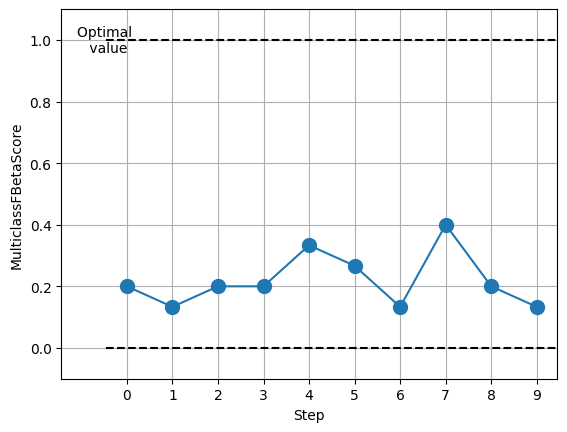

In [27]:
values = [ ]
for step in range(10):
    y_true = torch.randint(1, 5, (3,))
    for _ in range(5):
        y_pred = torch.randint(1, 5, (3,))
        fbeta.update(y_pred, y_true)
    values.append(fbeta.compute())  # Сохраняем метрику по "эпохе"
    fbeta.reset()
fig, ax = fbeta.plot(values) # Подаем метрики, которые сохранили списком

<div class="alert alert-info">

Мы посмотрели, как `TorchMetrics` помогает считать сложные метрики и даже рисовать графики. Но самая главная фишка, что `TorchMetrics` идеально работает с `Lightning` 😉

# <center id="p4"> 📏 TorchMetrics в PyTorch Lightning ⚡ </center>

<div class="alert alert-info">

**Torchmetrics** идеально клеится c **PyTorch Lightning**. Если вы используете их вместе, то вам надо сделать:
* Добавить ДВЕ метрики (одна - train, вторая - valid) в поле класса модели
* В методе `training_step` вызвать `self.train_metric(preds, target)`, а затем `self.log("train/metric", self.train_metric, on_step=True, on_epoch=False)`
* В методе `validation_step` делаем все аналогично

<div class="alert alert-success">

То есть модель должна выглядеть примерно так:

```python
class SuperPuperModel(L.LightningModule):
    def __init__(self, ..., num_classes):
        ...
        self.train_metric = tm.AUROC(task="multiclass", num_classes=num_classes)
        self.valid_metric = tm.AUROC(task="multiclass", num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        ...
        self.train_metric(preds, y)
        self.log('train/roc', self.train_metric, on_step=True, on_epoch=False)

    def validation_step(self, batch, batch_idx):
        logits = self(x)
        ...
        self.valid_metric(logits, y)
        self.log('valid/roc', self.valid_metric, on_step=True, on_epoch=True)
```

<div class="alert alert-info">

Давайте опробуем **Torchmetrics** на деле!

Отнаследуемся от нашей модели, чтобы не писать код повторно.

In [28]:
class SuperPuperModel(LightningModel):
    def __init__(self, cfg: CFG):
        super().__init__(cfg)

        self.train_metric_reg = tm.MeanAbsoluteError()
        self.train_metric_cls = tm.HingeLoss(task="multiclass", num_classes=cfg.num_tar_class)
        self.valid_metric_reg = tm.MeanAbsoluteError()
        self.valid_metric_cls = tm.HingeLoss(task="multiclass", num_classes=cfg.num_tar_class)
    
    # Перепишем basic step
    def basic_step(self, batch, batch_idx, step: str):
        data, reg_target, cls_target = batch

        pred_reg, pred_cls = self(data)

        # Обновляем метрики
        if step == "train":
            reg_metric = self.train_metric_reg(pred_reg, reg_target)
            cls_metric = self.train_metric_cls(pred_cls, cls_target)
        elif step == "valid":
            reg_metric = self.valid_metric_reg(pred_reg, reg_target)
            cls_metric = self.valid_metric_cls(pred_cls, cls_target)

        metrics = {
            f"{step}/loss": reg_metric + cls_metric,
            f"{step}/reg_loss": reg_metric,
            f"{step}/reg_class": cls_metric    
        }

        self.log_dict(metrics, prog_bar=True)

        return metrics

In [29]:
model = SuperPuperModel(cfg)
model

SuperPuperModel(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=9, bias=True)
  )
  (regression_criterion): MSELoss()
  (classification_criterion): CrossEntropyLoss()
  (train_metric_reg): MeanAbsoluteError()
  (train_metric_cls): MulticlassHingeLoss()
  (valid_metric_reg): MeanAbsoluteError()
  (valid_metric_cls): MulticlassHingeLoss()
)

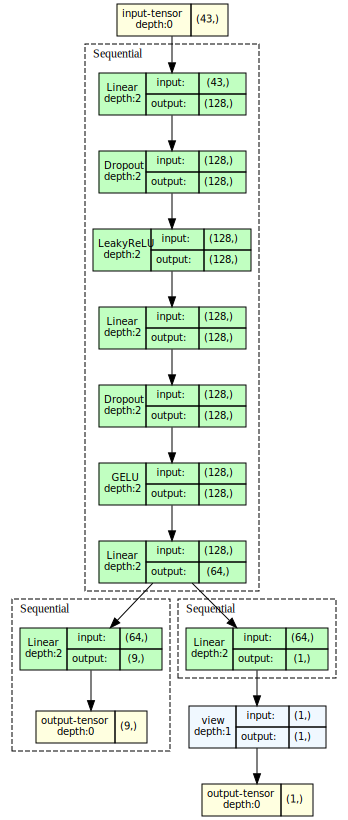

In [30]:
# Посмотрим какая модель у нас получилась
from torchview import draw_graph

model_graph = draw_graph(model, input_size=[cfg.num_features], expand_nested=True)
model_graph.visual_graph

<div class="alert alert-info">
    
Воспользуемся тренером, который обучал нашу модель раньше - он отлично справился со своей задачей!

In [31]:
trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    log_every_n_steps=10, # Как часто логируем метрики
    check_val_every_n_epoch=2, # Запускаем проверку val-части каждые 2 эпохи

    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=True, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Сохранение модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ],
    val_check_interval=0.2 # Запускать valid проверку каждые 0.2*epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model, datamodule=dataset)

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /app/storage_local/Course/ml_instruments/models/Lightning ⚡️ Improved exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type                | Params | Mode 
-------------------------------------------------------------------------
0 | mlp                      | Sequential          | 30.4 K | train
1 | regressor                | Sequential          | 65     | train
2 | classifier               | Sequential          | 585    | train
3 | regression_criterion     | MSELoss             | 0      | train
4 | classification_criterion | CrossEntropyLoss    | 0      | train
5 | train_metric_reg         | MeanAbsoluteError   | 0      | train
6 | train_metric_cls         | MulticlassHingeLoss | 0      | train
7 | valid_metric_reg         | MeanAbsoluteError   | 0      | train
8 | valid_metric_cls    

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: |                                                                                                 …

Metric valid/loss improved. New best score: 1.565


Validation: |                                                                                                 …

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.564


Validation: |                                                                                                 …

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.561


Validation: |                                                                                                 …

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.559


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.553


Validation: |                                                                                                 …

Metric valid/loss improved by 0.031 >= min_delta = 0.0. New best score: 1.522


Validation: |                                                                                                 …

Metric valid/loss improved by 0.011 >= min_delta = 0.0. New best score: 1.512


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.506


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.018 >= min_delta = 0.0. New best score: 1.488


Validation: |                                                                                                 …

Metric valid/loss improved by 0.015 >= min_delta = 0.0. New best score: 1.473


Validation: |                                                                                                 …

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.472


Validation: |                                                                                                 …

Metric valid/loss improved by 0.007 >= min_delta = 0.0. New best score: 1.465


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.009 >= min_delta = 0.0. New best score: 1.456


Validation: |                                                                                                 …

Metric valid/loss improved by 0.070 >= min_delta = 0.0. New best score: 1.387


Validation: |                                                                                                 …

Metric valid/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.379


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.374


Validation: |                                                                                                 …

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.371


Validation: |                                                                                                 …

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.369


Validation: |                                                                                                 …

Metric valid/loss improved by 0.024 >= min_delta = 0.0. New best score: 1.345


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.340


Validation: |                                                                                                 …

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.333


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.011 >= min_delta = 0.0. New best score: 1.322


Validation: |                                                                                                 …

Metric valid/loss improved by 0.027 >= min_delta = 0.0. New best score: 1.295


Validation: |                                                                                                 …

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.292


Validation: |                                                                                                 …

Metric valid/loss improved by 0.012 >= min_delta = 0.0. New best score: 1.280


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.018 >= min_delta = 0.0. New best score: 1.262


Validation: |                                                                                                 …

Metric valid/loss improved by 0.034 >= min_delta = 0.0. New best score: 1.228


Validation: |                                                                                                 …

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.226


Validation: |                                                                                                 …

Metric valid/loss improved by 0.007 >= min_delta = 0.0. New best score: 1.219


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.213


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.211


Validation: |                                                                                                 …

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.205


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.004 >= min_delta = 0.0. New best score: 1.200


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.004 >= min_delta = 0.0. New best score: 1.197


Validation: |                                                                                                 …

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.195


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.193


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.010 >= min_delta = 0.0. New best score: 1.183


Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


<div class="alert alert-success">

⛓️ Теперь при необходимости добавить новую метрику или изменить лосс в модели - мы можем не переживать, что она не запустится или не обучится. Так как все метрики из `TorchMetrics` имеют одинаковый интерфейс.

# <center id="p5"> 🎚 Tuner - подбираем идеальные гиперпараметры! </center>

<div class="alert alert-info">

Что если вы хотите подобрать начальный `learning rate`, чтобы моделька хорошо обучалась, или же оптимизировать `batch size`, дабы влезло в `GPU`, но не хотите делать это вручную? В `Lightning` есть модуль `Tuner`, который позволяет подбирать эти параметры в автоматическом режиме

Давайте посмотрим как его использовать!


## <center> 🕘 LR finder </center>

In [33]:
model = SuperPuperModel(cfg)
trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=True, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Сохранение модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ],
    val_check_interval=0.2 # Запускать valid проверку каждые 0.2*epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
tuner = pl.tuner.Tuner(trainer) # Создаем тюнер

In [35]:
lr_finder = tuner.lr_find(model, datamodule=dataset) # Ищем оптимальный learning rate

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at /app/storage_local/Course/ml_instruments/notebooks/.lr_find_2d7dcfbc-0949-4726-b511-ad90d0b5fe6c.ckpt
Restored all states from the checkpoint at /app/storage_local/Course/ml_instruments/notebooks/.lr_find_2d7dcfbc-0949-4726-b511-ad90d0b5fe6c.ckpt


In [36]:
lr_finder.suggestion()

0.030199517204020192

<div class="alert alert-info">

`Lightning` нашел нам оптимальный `learning rate` буквально в 2 строчки кода! Как же прекрасен этот инструмент 🤗

## <center> 💻 Batch Size, чтобы уместилось на GPU </center>

<div class="alert alert-success">

Давайте посмотрим как находить оптимальный `batch size` 

In [37]:
model = SuperPuperModel(cfg)
trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=True, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Сохранение модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ],
    val_check_interval=0.2 # Запускать valid проверку каждые 0.2*epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [38]:
# Ищем batch_size для train части и для valid части 
bs_finder_train = tuner.scale_batch_size(model, datamodule=dataset, method='fit')
bs_finder_valid = tuner.scale_batch_size(model, datamodule=dataset, method='validate')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 succeeded, trying batch size 64
/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 64 succeeded, trying batch size 128
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 128 succeeded, trying batch size 256
/app/

In [39]:
bs_finder_train, bs_finder_valid

(2048, 2048)

# <center id="p6"> 🧸 Выводы и заключения ✅ </center>

<div class="alert alert-success">
    
В этом уроке мы:
- Научились обучать нейронки с помощью `Trainer`. Он помогает вам сконцентрироваться на логике модели, а не на ее обучении
- Узнали какие есть фишки в `Trainer` и познакомились с `callbacks`
- Освоили `Torchmetrics`, как прекрасное дополнение метрикам из `torch.nn`
- Добавили в свой арсенал связку `Lightning` + `Torchmetrics`
- Овладели инструментом `Tuner` для поиска лучших гиперпараметров модели 